In [18]:
import numpy as np
import matplotlib.pyplot as plt
from gco import pygco 
import cv2
import sys

def calculate_color_distance(a, b):
    # 计算两个RGB颜色之间的绝对颜色距离 # Calculate the absolute color distance between two RGB colors
    return np.mean((a.astype(float)-b.astype(float))**2)

#读入CameraShiftMatrix矩阵，并将K、T、R保存备用 # Read the CameraShiftMatrix matrix and save K, T, and R for later use
CameraShiftMatrix = np.loadtxt('cameras.txt', dtype=np.float32)
K1 = CameraShiftMatrix[0:3, 0:3]
R1 = CameraShiftMatrix[3:6, 0:3]
T1 = CameraShiftMatrix[6:7, 0:3].T
K2 = CameraShiftMatrix[7:10, 0:3]
R2 = CameraShiftMatrix[10:13, 0:3]
T2 = CameraShiftMatrix[13:14, 0:3].T
print('K1\n', K1, '\nR1\n', R1, '\nT1\n', T1, '\nK2\n', K2, '\nR2\n', R2, '\nT2\n', T2)


K1
 [[1.221227e+03 0.000000e+00 4.795000e+02]
 [0.000000e+00 1.221227e+03 2.695000e+02]
 [0.000000e+00 0.000000e+00 1.000000e+00]] 
R1
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 
T1
 [[0.]
 [0.]
 [0.]] 
K2
 [[1.221227e+03 0.000000e+00 4.795000e+02]
 [0.000000e+00 1.221227e+03 2.695000e+02]
 [0.000000e+00 0.000000e+00 1.000000e+00]] 
R2
 [[ 0.9998813   0.01489949  0.0039107 ]
 [-0.01489076  0.9998866  -0.00225327]
 [-0.00394383  0.00219477  0.9999898 ]] 
T2
 [[-9.990979  ]
 [ 0.24517421]
 [ 0.16508327]]


$ x'^h \sim K_{t'} R_{t'}^T R_t K_t^{-1} x^h + d_x K_{t'} R_{t'}^T (T_t - T_{t'}) $

In [19]:
# 加载图片 # load the images
image1 = cv2.imread('test00.jpg')
image2 = cv2.imread('test09.jpg')
image1 = cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

Height1, Width1, _ = image1.shape
Height2, Width2, _ = image2.shape

#初始化参数 #Initialization parameters
SizeofLayers = 50
disparity = np.linspace(0,SizeofLayers,SizeofLayers+1)

PairwisePotentialEnergyMatrix = np.zeros((SizeofLayers, SizeofLayers))
for i in range(SizeofLayers):
    for j in range(SizeofLayers):
        PairwisePotentialEnergyMatrix[i, j] = ((i - j)**2)/((SizeofLayers-1)**2)

UnaryPotentialArray = np.zeros([Height1, Width1, SizeofLayers])

ParameterMatrix1 = K2 @ R2.T @ R1 @ np.linalg.inv(K1)
ParameterMatrix2 = K2 @ R2.T @ (T1-T2)

print('PairwisePotentialEnergyMatrix\n', PairwisePotentialEnergyMatrix, "\n")
print('ParameterMatrix1\n', ParameterMatrix1, '\n', 'ParameterMatrix2\n', ParameterMatrix2)


disparity
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.] 

PairwisePotentialEnergyMatrix
 [[0.00000000e+00 4.16493128e-04 1.66597251e-03 ... 9.20033319e-01
  9.59600167e-01 1.00000000e+00]
 [4.16493128e-04 0.00000000e+00 4.16493128e-04 ... 8.81299459e-01
  9.20033319e-01 9.59600167e-01]
 [1.66597251e-03 4.16493128e-04 0.00000000e+00 ... 8.43398584e-01
  8.81299459e-01 9.20033319e-01]
 ...
 [9.20033319e-01 8.81299459e-01 8.43398584e-01 ... 0.00000000e+00
  4.16493128e-04 1.66597251e-03]
 [9.59600167e-01 9.20033319e-01 8.81299459e-01 ... 4.16493128e-04
  0.00000000e+00 4.16493128e-04]
 [1.00000000e+00 9.59600167e-01 9.20033319e-01 ... 1.66597251e-03
  4.16493128e-04 0.00000000e+00]] 

ParameterMatrix1
 [[ 1.0014168e+00 -1.5775476e-02 -1.2490540e+00]
 [ 1.5762506e-02  9.9938929e-01 -4.7159729e+00]
 [ 3.2022701e-06 -1.8450838e-06 

In [21]:
for y in range(0, Height1):
    sys.stdout.write("\rProgress: {:.1%}".format(y/Height1))
    sys.stdout.flush()
    for x in range(0, Width1):
        xh = np.array([[x], [y], [1]])
        for i in range(0, SizeofLayers):
            new_xh = ParameterMatrix1 @ xh + disparity[i] * ParameterMatrix2
            new_xh = np.round(new_xh/new_xh[2])
            
            if new_xh[1] < 0:
                new_xh[1] = 0
            elif new_xh[1] > Height1-1:
                new_xh[1] = Height1-1
                
            if new_xh[0] < 0:
                new_xh[0] = 0
            elif new_xh[0] > Width1-1:
                new_xh[0] = Width1-1
            
            pixel1 = image1[y][x]
            pixel2 = image2[int(new_xh[1])][int(new_xh[0])]
                
            UnaryPotentialArray[y][x][i] = calculate_color_distance(pixel1, pixel2) / 255

Progress: 0.0%

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_118680\2303744362.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pixel2 = image2[int(new_xh[1])][int(new_xh[0])]


Progress: 99.8%

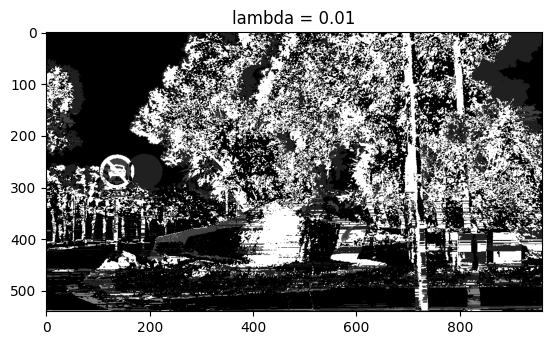

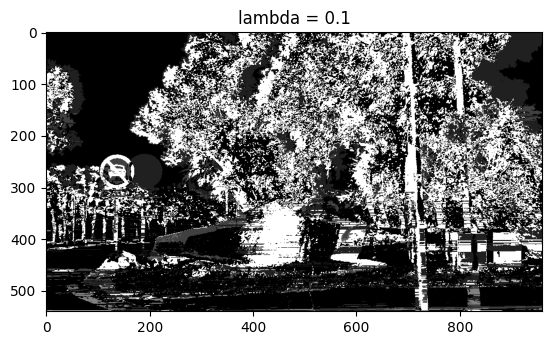

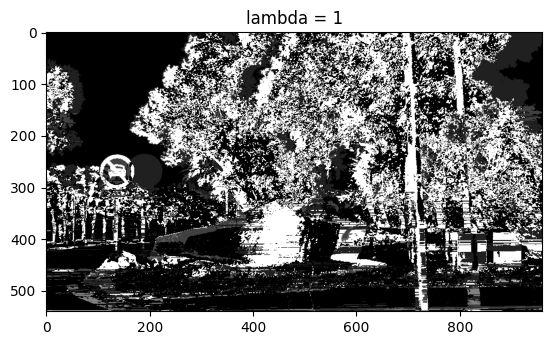

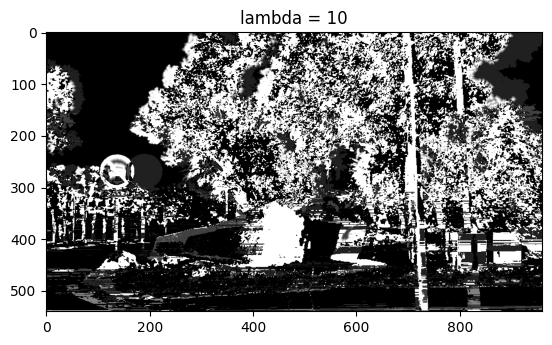

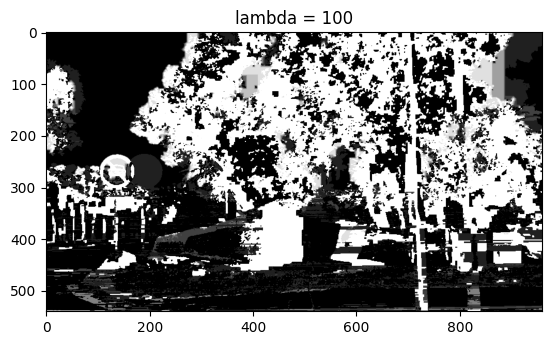

In [24]:

lambda_values = [0.01, 0.1, 1, 10, 100]

for loop_lambda in lambda_values:
    label = pygco.cut_grid_graph_simple(UnaryPotentialArray, PairwisePotentialEnergyMatrix*loop_lambda, n_iter=-1, algorithm='swap')
    label = label.reshape(Height1, Width1)
    plt.imshow(label, cmap='gray')
    plt.title(f'lambda = {loop_lambda}')
    plt.show()

It can generally distinguish between foreground objects and distant views, but the depth division of the foreground is not clear enough.

Considering that the distance of the sky is approximately infinite, try to use non-uniform disparity to process the image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gco import pygco 
import cv2
import sys
import math

def calculate_color_distance(a, b):
    # 计算两个RGB颜色之间的绝对颜色距离 # Calculate the absolute color distance between two RGB colors
    return np.mean((a.astype(float)-b.astype(float))**2)

#读入CameraShiftMatrix矩阵，并将K、T、R保存备用 # Read the CameraShiftMatrix matrix and save K, T, and R for later use
CameraShiftMatrix = np.loadtxt('cameras.txt', dtype=np.float32)
K1 = CameraShiftMatrix[0:3, 0:3]
R1 = CameraShiftMatrix[3:6, 0:3]
T1 = CameraShiftMatrix[6:7, 0:3].T
K2 = CameraShiftMatrix[7:10, 0:3]
R2 = CameraShiftMatrix[10:13, 0:3]
T2 = CameraShiftMatrix[13:14, 0:3].T
print('K1\n', K1, '\nR1\n', R1, '\nT1\n', T1, '\nK2\n', K2, '\nR2\n', R2, '\nT2\n', T2)

# 加载图片 # load the images
image1 = cv2.imread('test00.jpg')
image2 = cv2.imread('test09.jpg')
image1 = cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

Height1, Width1, _ = image1.shape
Height2, Width2, _ = image2.shape

#尝试使用非均匀的disparity #use non-uniform disparity
SizeofLayers = 50
disparity = [math.exp(i/10) for i in range(SizeofLayers+1)]

PairwisePotentialEnergyMatrix = np.zeros((SizeofLayers, SizeofLayers))
for i in range(SizeofLayers):
    for j in range(SizeofLayers):
        PairwisePotentialEnergyMatrix[i, j] = ((i - j)**2)/((SizeofLayers-1)**2)

UnaryPotentialArray = np.zeros([Height1, Width1, SizeofLayers])

ParameterMatrix1 = K2 @ R2.T @ R1 @ np.linalg.inv(K1)
ParameterMatrix2 = K2 @ R2.T @ (T1-T2)

print('PairwisePotentialEnergyMatrix\n', PairwisePotentialEnergyMatrix, "\n")
print('ParameterMatrix1\n', ParameterMatrix1, '\n', 'ParameterMatrix2\n', ParameterMatrix2)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\gco_wrapper-3.0.9-py3.11-win-amd64.egg\gco\__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


K1
 [[1.221227e+03 0.000000e+00 4.795000e+02]
 [0.000000e+00 1.221227e+03 2.695000e+02]
 [0.000000e+00 0.000000e+00 1.000000e+00]] 
R1
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 
T1
 [[0.]
 [0.]
 [0.]] 
K2
 [[1.221227e+03 0.000000e+00 4.795000e+02]
 [0.000000e+00 1.221227e+03 2.695000e+02]
 [0.000000e+00 0.000000e+00 1.000000e+00]] 
R2
 [[ 0.9998813   0.01489949  0.0039107 ]
 [-0.01489076  0.9998866  -0.00225327]
 [-0.00394383  0.00219477  0.9999898 ]] 
T2
 [[-9.990979  ]
 [ 0.24517421]
 [ 0.16508327]]
PairwisePotentialEnergyMatrix
 [[0.00000000e+00 4.16493128e-04 1.66597251e-03 ... 9.20033319e-01
  9.59600167e-01 1.00000000e+00]
 [4.16493128e-04 0.00000000e+00 4.16493128e-04 ... 8.81299459e-01
  9.20033319e-01 9.59600167e-01]
 [1.66597251e-03 4.16493128e-04 0.00000000e+00 ... 8.43398584e-01
  8.81299459e-01 9.20033319e-01]
 ...
 [9.20033319e-01 8.81299459e-01 8.43398584e-01 ... 0.00000000e+00
  4.16493128e-04 1.66597251e-03]
 [9.59600167e-01 9.20033319e-01 8.81299459e-01 ... 4.16493128e-04

In [2]:
for y in range(0, Height1):
    sys.stdout.write("\rProgress: {:.1%}".format(y/Height1))
    sys.stdout.flush()
    for x in range(0, Width1):
        xh = np.array([[x], [y], [1]])
        for i in range(0, SizeofLayers):
            new_xh = ParameterMatrix1 @ xh + disparity[i] * ParameterMatrix2
            new_xh = np.round(new_xh/new_xh[2])
            
            if new_xh[1] < 0:
                new_xh[1] = 0
            elif new_xh[1] > Height1-1:
                new_xh[1] = Height1-1
                
            if new_xh[0] < 0:
                new_xh[0] = 0
            elif new_xh[0] > Width1-1:
                new_xh[0] = Width1-1
            
            pixel1 = image1[y][x]
            pixel2 = image2[int(new_xh[1])][int(new_xh[0])]
                
            UnaryPotentialArray[y][x][i] = calculate_color_distance(pixel1, pixel2) / 255

Progress: 0.0%

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_117212\2303744362.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pixel2 = image2[int(new_xh[1])][int(new_xh[0])]


Progress: 99.8%

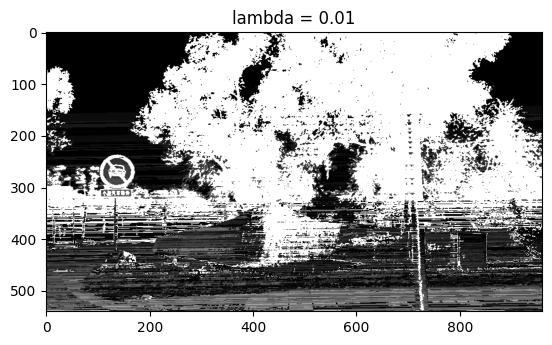

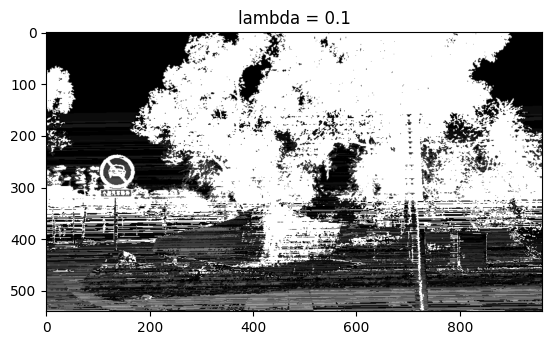

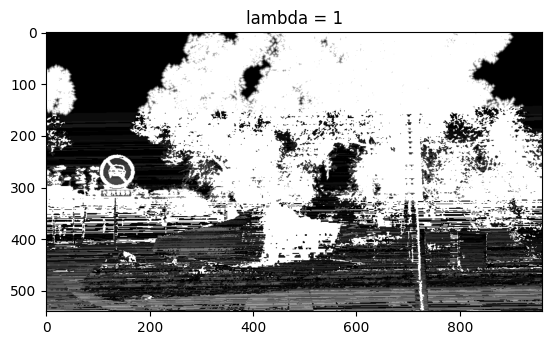

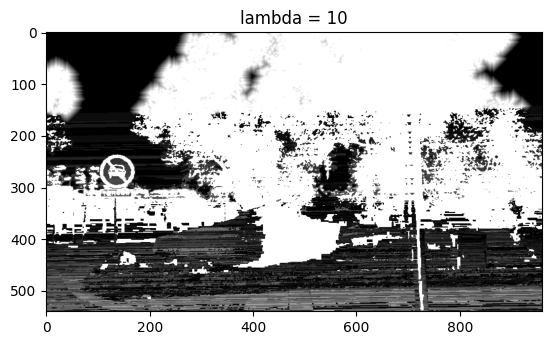

In [4]:
lambda_values = [0.01, 0.1, 1, 10]

for loop_lambda in lambda_values:
    label = pygco.cut_grid_graph_simple(UnaryPotentialArray, PairwisePotentialEnergyMatrix*loop_lambda, n_iter=-1, algorithm='swap')
    label = label.reshape(Height1, Width1)
    plt.imshow(label, cmap='gray')
    plt.title(f'lambda = {loop_lambda}')
    plt.show()

The effect has been improved somewhat and can show some depth information of the road surface compared with the previous result.